In [1]:
from sklearn import datasets

iris = datasets.load_iris()

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

In [3]:
import matplotlib.pyplot as plt

# Let's try the algorithm

First of all we select the middle class as outlier (label = 1) since it's a bit harder than the others.
In fact by being in the middle of the other two, the sphere projection must split.

In [4]:
X = iris.data
y = [0] * 50 + [1] * 50 + [0] * 50
colors = ['red' if i == 1 else 'green' for i in y]

We scale the data and reduce the components to two, just to work in a easy to visualize environment.

In [5]:
X_scaled = MaxAbsScaler().fit_transform(X)
X_reduced = PCA(n_components=2).fit_transform(X_scaled)

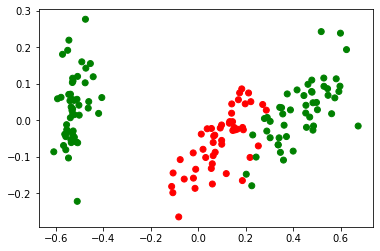

In [6]:
plt.scatter(X_reduced[:,0],X_reduced[:,1], c=colors)
plt.show()

In [7]:
import sys

sys.path.append('..')

from flod.classifiers.bsvclassifier import BSVClassifier

We keep only 33% of the dataset as test set.

We shuffle and stratify, since the outliers are not the same amount as the regular points.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.33, shuffle=True, stratify=y)

In [9]:
clf = BSVClassifier(n_iter=10, c=.25, q=100, penalization=200)
clf.fit(X_train, y_train)

Estimated kernel_values size 1.6722828149795532e-05 GB


BSVClassifier(c=0.25, n_iter=10, penalization=200, q=100)

In [10]:
y_pred = clf.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f'Precision {precision_score(y_test, y_pred)}')
print(f'Recall {recall_score(y_test, y_pred)}')
print(f'F1 {f1_score(y_test, y_pred)}')
print(f'Accuracy {accuracy_score(y_test, y_pred)}')

Precision 0.8823529411764706
Recall 0.8823529411764706
F1 0.8823529411764706
Accuracy 0.92


In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        33
           1       0.88      0.88      0.88        17

    accuracy                           0.92        50
   macro avg       0.91      0.91      0.91        50
weighted avg       0.92      0.92      0.92        50



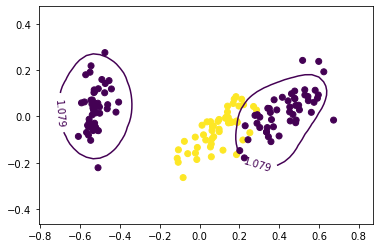

In [13]:
gx = np.linspace(min(X_reduced[:,0])-.2, max(X_reduced[:,0])+.2, 50)
gy = np.linspace(min(X_reduced[:,1])-.2, max(X_reduced[:,1])+.2, 50)
gX, gY = np.meshgrid(gx, gy)
zs = np.array([clf._compute_r(np.array([x, y])) for x, y in zip(np.ravel(gX), np.ravel(gY))])
gZ = zs.reshape(gX.shape)
membership_contour = plt.contour(gX, gY, gZ, levels=(clf.radiuses_[clf.sv_i], ))
plt.clabel(membership_contour, inline=1)

plt.scatter(X_reduced[:,0],X_reduced[:,1], c=y)
plt.show()

In [14]:
from joblib import dump, load
dump(clf, 'iris.joblib') 

['iris.joblib']

# Let's setup a Pipeline

We split train and test the same as above.

In [15]:
from scipy.stats import randint, uniform
from sklearn.model_selection import cross_validate
from tqdm.notebook import tqdm

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold


pipe = Pipeline([
        ('scaler', MaxAbsScaler()),
        ('reduce_dim', PCA('mle')),
        ('classifier', BSVClassifier())
])

params = {
    'scaler': [StandardScaler(), MaxAbsScaler(), RobustScaler(), QuantileTransformer()],
    'classifier__n_iter': [10],
    'classifier__penalization': randint(0, 500),
    'classifier__q': randint(0, 500),
    'classifier__c': uniform()    
}

scoring = ['precision', 'recall', 'f1']

Inner loop aka RandomizedSearchCV to find the best model given the data.
Outer loop to see if the best model was just lucky or all the best models perform well.

In [17]:
outer_cv = StratifiedKFold(n_splits=10, shuffle=True)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True)


clf = RandomizedSearchCV(pipe, params, n_jobs=-1, cv=inner_cv, refit='f1', verbose=10, return_train_score=False, scoring=scoring, n_iter=10)
scores = cross_validate(clf, X=X, y=y, cv=outer_cv, n_jobs=-1, scoring=scoring, verbose=10, return_estimator=True, return_train_score=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 106.2min remaining: 106.2min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 112.7min remaining: 48.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 155.4min finished


In [18]:
scores

{'fit_time': array([3517.64639902, 3389.93425107, 3710.90846395, 3711.33131814,
        2974.65280819, 2978.01552415, 3044.40738368, 3062.83801293,
        2851.70627785, 2822.80552721]),
 'score_time': array([0.06298614, 0.06480885, 0.0604279 , 0.06227589, 0.06497216,
        0.06216884, 0.06191206, 0.04954004, 0.03390193, 0.02894688]),
 'estimator': (RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                     estimator=Pipeline(steps=[('scaler', MaxAbsScaler()),
                                               ('reduce_dim',
                                                PCA(n_components='mle')),
                                               ('classifier', BSVClassifier())]),
                     n_jobs=-1,
                     param_distributions={'classifier__c': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fed13af5df0>,
                                          'classifier__n_iter': [10],
                                   

In [19]:
import pandas as pd

cv_res = pd.DataFrame(scores)
cv_res

,fit_time,score_time,estimator,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,3517.646399,0.062986,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,0.571429,0.851064,0.8,0.888889,0.666667,0.869565
1,3389.934251,0.064809,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,1.000000,0.883721,1.0,0.844444,1.000000,0.863636
2,3710.908464,0.060428,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,1.000000,0.951220,0.8,0.866667,0.888889,0.906977
3,3711.331318,0.062276,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,0.833333,0.891304,1.0,0.911111,0.909091,0.901099
4,2974.652808,0.064972,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,0.714286,0.875000,1.0,0.933333,0.833333,0.903226
5,2978.015524,0.062169,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,0.800000,0.843137,0.8,0.955556,0.800000,0.895833
6,3044.407384,0.061912,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,0.833333,0.953488,1.0,0.911111,0.909091,0.931818
7,3062.838013,0.049540,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,1.000000,1.000000,1.0,0.866667,1.000000,0.928571
8,2851.706278,0.033902,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,0.800000,0.914894,0.8,0.955556,0.800000,0.934783
9,2822.805527,0.028947,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,0.666667,1.000000,0.8,0.888889,0.727273,0.941176


In [20]:
print(f'Average precision: {np.average(cv_res["test_precision"]):.2f}')
print(f'Std precision: {np.std(cv_res["test_precision"]):.2f}')

print(f'\nAverage recall: {np.average(cv_res["test_recall"]):.2f}')
print(f'Std recall: {np.std(cv_res["test_recall"]):.2f}')

print(f'\nAverage recall: {np.average(cv_res["test_f1"]):.2f}')
print(f'Std recall: {np.std(cv_res["test_f1"]):.2f}')

Average precision: 0.82
Std precision: 0.14

Average recall: 0.90
Std recall: 0.10

Average recall: 0.85
Std recall: 0.10
